In [1]:
%pip install torch
%pip install torchvision
%pip install numpy
%pip install torchsummary
%pip install tqdm
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 6.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.1 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import datasets, transforms

# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [6]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        drop_out_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        nn.AvgPool2d(kernel_size=8)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1 7x7x10 | 7x7x10x10 | 1x1x10


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [15]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
summary(model, input_size=(1, 28, 28)) 

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
model = Net().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           2,880
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]           2,880
             ReLU-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
          Dropout-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14           [-1, 10,

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1767520308494568 Batch_id=937 Accuracy=91.11: 100%|██████████| 938/938 [00:14<00:00, 64.62it/s]  



Test set: Average loss: 0.0936, Accuracy: 9731/10000 (97.31%)

EPOCH: 1


Loss=0.028956221416592598 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:11<00:00, 84.42it/s] 



Test set: Average loss: 0.0623, Accuracy: 9810/10000 (98.10%)

EPOCH: 2


Loss=0.018772248178720474 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [00:11<00:00, 84.43it/s] 



Test set: Average loss: 0.0506, Accuracy: 9847/10000 (98.47%)

EPOCH: 3


Loss=0.30687326192855835 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:11<00:00, 84.52it/s]  



Test set: Average loss: 0.0389, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.00534027349203825 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:11<00:00, 84.52it/s]  



Test set: Average loss: 0.0375, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.004204640164971352 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:11<00:00, 84.69it/s] 



Test set: Average loss: 0.0347, Accuracy: 9887/10000 (98.87%)

EPOCH: 6


Loss=0.0249678622931242 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:11<00:00, 83.90it/s]   



Test set: Average loss: 0.0380, Accuracy: 9875/10000 (98.75%)

EPOCH: 7


Loss=0.005534225143492222 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:11<00:00, 84.03it/s] 



Test set: Average loss: 0.0305, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.00044065824477002025 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:11<00:00, 84.78it/s]



Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.001886687008664012 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:11<00:00, 84.84it/s]  



Test set: Average loss: 0.0389, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.01039981096982956 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:11<00:00, 85.01it/s]   



Test set: Average loss: 0.0373, Accuracy: 9880/10000 (98.80%)

EPOCH: 11


Loss=0.0047291419468820095 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:10<00:00, 85.46it/s] 



Test set: Average loss: 0.0318, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.0007420301553793252 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:10<00:00, 85.46it/s] 



Test set: Average loss: 0.0297, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


Loss=0.0006898530991747975 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:11<00:00, 84.49it/s] 



Test set: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

EPOCH: 14


Loss=0.008413056842982769 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:11<00:00, 84.27it/s]  



Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)



Text(0.5, 1.0, 'Test Accuracy')

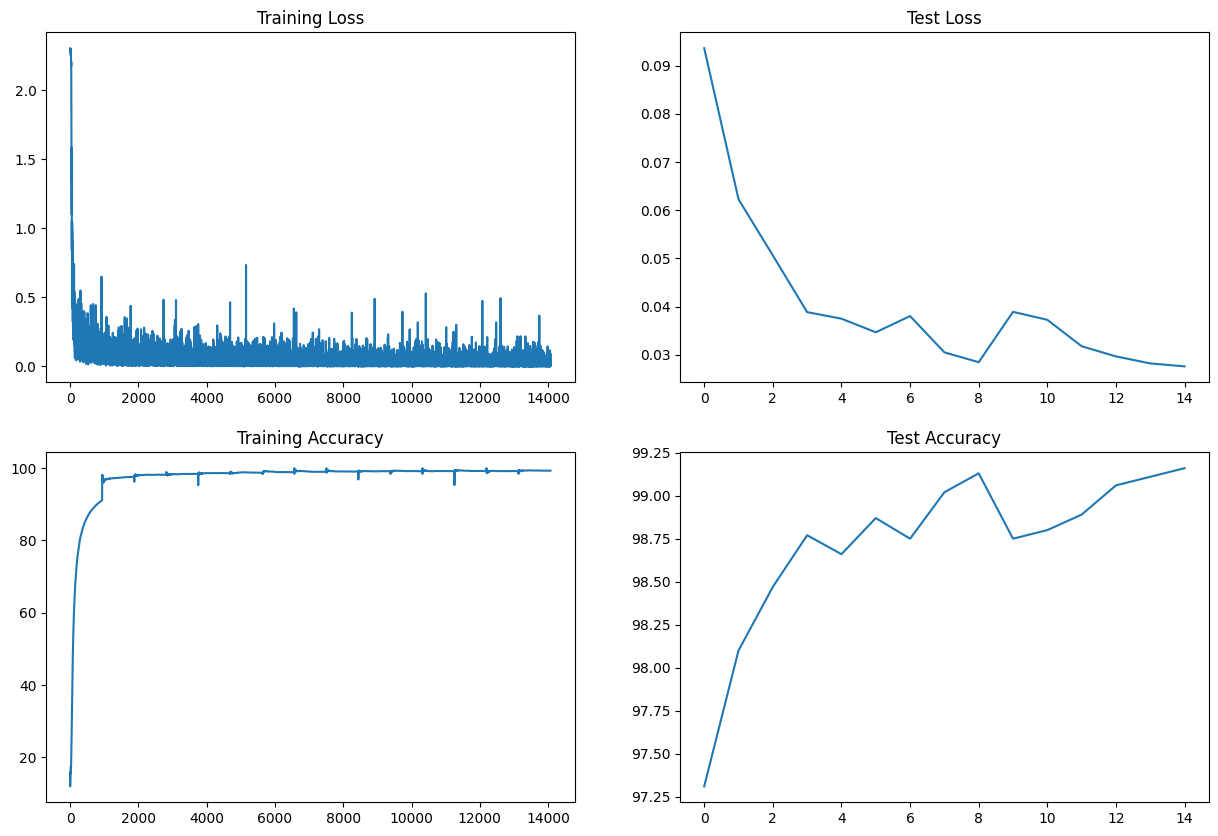

In [20]:
t = [t_items.item() for t_items in train_losses]


import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**
  
*   Reduce parameters bellow 20k count
*   Make sure, defined model get trained
*   Limit the 15 epoch


**Results:**


*   Parameters: 12,854
*   Best Training Accuracy: 99.32
*   Best Test Accuracy: 99.16


**Analysis:**


*   Light weight Model
*   Added Batch Normalization, MaxPool2d and dropout = 0.1
*   Initial 5 epocs has more test accuracy than training accuracy